In [1]:
# IMPORT REQUIRED LIBRARIES
import os
import re
import sys
import pandas as pd
import numpy as np

# 1. Import raw text and tokenize

In [2]:
"""
Take a source of text and create a python list of all the words.
The words retain the same sequence and frequence as in original text.
INPUT:
    data_source, text file, Content will be parsed for sentences. This should be a plain text document

OUTPUT:
    tokens, list<list>, list of lists containing a one to one mapping of all the words in the provided text.
"""
view_tokens=False
data_source = 'data/medical_docs_content.txt'


#open input file and tokenize
tokens = []
with open(data_source, 'r') as source:
    for line in source:
        line = re.sub(r'\W', ' ', line) 
        line_tokens = line.split( )
        line_tokens = [token.strip().lower() for token in line_tokens]
        tokens.append(line_tokens)

if (view_tokens):
    for idx in range(2):
        print tokens[idx]

print "DONE creating tokens, saved in variable 'tokens'"

DONE creating tokens, saved in variable 'tokens'


# 2. Create a word2vec model from tokens

In [3]:
"""
Source: Natural Language Processing in Action, Chapter 6
Section: 6.5.2 Training domain specific word2vec model
INPUT:
    tokens, python list, Tokenized data from previous step.
    model_path, string, path where we will saved trained model from tokens (depends on last steps data_source)
OUTPUT:
    model_path, <File on disk> a word2vec trained model from the original tokens.  (hidden weights only)
"""
from gensim.models import word2vec

model_path  = "models/{}".format(re.compile(r'\..*').sub('', os.path.basename(data_source)))

model = word2vec.Word2Vec(
    tokens,              # Our array of sentences, each of which is an array of words.
    min_count=3,         # Min number of word count to be considered
    workers=4,           # Number of threads in parallel. (cores on laptop)
    size=300,            # The number of weights in hidden layer, (length of word verctors)
    window=6,            # Context window size
    sample=1e-3          # subsampling rate for frequent terms
)

# Save disk space by saving only hidden neurons.  (We lose output weights)
model.init_sims(replace=True)

model.save(model_path)

print "New model saved to {}".format(model_path)

New model saved to models/medical_docs_content


# 3. Import model and test it by looking for similar words..

In [62]:
"""
Load a previously saved word2vec model and use vector math to find words deemed 'similar'

INPUT:
    model_path: string, path to file containing previously trained set of word2vec vectors.
OUTPUT:
    positive: list<string>, a list of words to find similar words to.
    negavite: list<string>, a list of words whose vectors get subtracted before finding similarity

Output is displayed to console.
"""
import pandas as pd
from gensim.models import KeyedVectors
from gensim.models import word2vec

# INTPUTS:
positive = ['doctor']
negative = []

model = word2vec.Word2Vec.load(model_path)
results = model.most_similar(positive=positive, negative=negative, topn=20)
# print results
data = pd.DataFrame(results)

print "Positive: {}".format(positive)
print "Negative: {}".format(negative)
print data.head(10)

Positive: ['doctor']
Negative: []
             0         1
0      doctors  0.965073
1      assures  0.953188
2     protocol  0.952838
3     reviewed  0.947542
4   concerning  0.944725
5        greet  0.944284
6  accordingly  0.943018
7  medications  0.942222
8     messages  0.941312
9       advise  0.940864


# 4. Create a 2D map from the vectors in the saved model.  (Retina)

In [5]:
"""
This section creates the semantic map from the hidden layer vectors.
	1. Open a pretrained vector set 'data_for_classification_model'
	2. collect all vectors into one single 2d numpy array
	3. pass 2d array to minisom and train a map
	4. Save the map to som_map
    
INPUTS:
    model_path, string, path to file for previously trained model from raw text
    vectors_path, string, path to file where only numerical vectors will be saved to pass to minisom
    weights_path, string, path to map weights defining the trained 2d minisom
    b_collect_new_vectors, boolean, recollect the vector file (if we updated the model)
    b_save_new_som_weights, boolean, recalculate and overwrite the weights for the 2d map.
    training inputs:
    _sigma: float
    _learning_rate: float
    _train_iterations: int
OUTPUT:
    Depending on the booleans, the files at vectors_path and weights_path will be overwritten or created.
"""
from minisom import MiniSom
from gensim.models import KeyedVectors
from gensim.models import word2vec
import numpy as np 

#INPUTS
b_collect_new_vectors = True
b_save_new_som_weights = True 
vectors_path = 'models/vectors_array'
weights_path = 'models/som_weights_3'
# TRAINING INPUTS
_sigma = 5
_learning_rate = 0.8
_train_iterations = 200
#ENDINPUTS


print "Loading model {}".format(model_path)
word_vectors = KeyedVectors.load(model_path)
model = word2vec.Word2Vec.load(model_path)

if (b_collect_new_vectors):
    print "Saving 2d numpy array from word_vectors to {}".format(vectors_path)
    varrs = np.array([word_vectors[word] for word in word_vectors.wv.vocab.keys()])
    np.save(vectors_path, varrs)
else:
    print "Loading {}.py word vectors from disk".format(vectors_path)
    varrs = np.load("{}.npy".format(vectors_path))

print varrs.shape
som = MiniSom(x=128, y=128, input_len=300, sigma=_sigma, learning_rate=_learning_rate)
som.random_weights_init(varrs)
if (b_save_new_som_weights):
    print "Training:"
    print "sigma:", _sigma, "learning_rate:", _learning_rate, "train_iterations:",_train_iterations
    som.train_random(varrs, _train_iterations) # random training

    print "Saving {}".format(weights_path)
    np.save(weights_path, som.weights)


            
print "DONE"

Loading model models/medical_docs_content
Saving 2d numpy array from word_vectors to models/vectors_array
(6994, 300)
Training:
sigma: 5 learning_rate: 0.8 train_iterations: 200
Saving models/som_weights_3
DONE


# 5. Create a list of word 'fingerprints'

In [6]:
print len(tokens)
unique_words = []
for line_list in tokens:
    for word in line_list:
        if word not in unique_words:
            unique_words.append(word)

print len(unique_words)

som.weights = np.load("{}.npy".format(weights_path))


stop = 2
for word in unique_words:
    print word
    try:
        print model.most_similar(positive=[word], negative=[], topn=5)
        print som.winner(word_vectors[word])
    except:
        print word, "not in vocabulary"
    stop -= 1
    if stop < 0:
        break

        



4608
13210
valuethis
valuethis not in vocabulary
position
[('endeavor', 0.8360309600830078), ('this', 0.8241738080978394), ('funded', 0.8029907941818237), ('requires', 0.7990128993988037), ('exempt', 0.76841139793396)]
(71, 123)
will
[('would', 0.803634762763977), ('considered', 0.7921169996261597), ('successful', 0.7566119432449341), ('candidate', 0.7432190775871277), ('should', 0.7295222282409668)]
(95, 47)


In [45]:
def generate_word_to_loc(unique_words, word_vectors, som):
    print "Generating word to location dictionary"
    print "Number of unique words is {}".format(len(unique_words))
    word_to_loc = {}
    for word in unique_words:
        try:
            word_to_loc[word] = som.winner(word_vectors[word])
        except:
            pass
    print "Completed,word_to_loc is {}".format(len(word_to_loc))
    return word_to_loc

word_to_loc = generate_word_to_loc(unique_words, word_vectors, som)

def generate_fingerprint_dictionary(word_to_loc, model):
    fingerprints = {}
    for word, loc in word_to_loc.iteritems():
            fingerprints[word] = [loc]
            similar_words = model.most_similar(positive=[word], negative=[], topn=20)
            [fingerprints[word].append(word_to_loc[tup[0]]) for tup in similar_words] 
    print "Completed fingerprints with length {}".format(len(fingerprints))
    return fingerprints

fingerprints = generate_fingerprint_dictionary(word_to_loc, model)

 Generating word to location dictionary
Number of unique words is 13210
Completed,word_to_loc is 6994
Completed fingerprints with length 6994


In [48]:

class Retina:
    def __init__(self, _unique_words, _trained_som, _word_vectors, _model, 
                 _word_to_loc, _fingerprints):
        self.unique_words = _unique_words
        self.som = _trained_som
        self.word_vectors = _word_vectors
        self.model = _model
        self.word_to_loc = _word_to_loc
        self._fingerprints = _fingerprints

         
    def location(self, word):
        return self.word_to_loc[word]

    def fingerprint(self, item):
        if type(item) == type('word'):
            return self._fingerprints[item]
        elif type(item) == type([]):
            tups = []
            for word in item:
                for tup in self.fingerprint(word):
                    if tup not in tups:
                        tups.append(tup)

            return tups
            

    def fingerprint_x_y(self, word):
        xarr = []
        yarr = []
        for tup in self.fingerprint(word):
            xarr.append(tup[0])
            yarr.append(tup[1])

        return (xarr, yarr)
    

retina = Retina(unique_words, som, word_vectors, model, word_to_loc, fingerprints)

In [49]:
print "Location for medical", retina.location('medical')
print "---------"
print "Fingerprint for medical", retina.fingerprint('medical')
print "---------"
print "Fingerprint for array medical", retina.fingerprint(['medical'])
print "---------"
print "XY Fingerprint for medical", retina.fingerprint_x_y('medical')
print "---------"
print "XY Fingerprint for array medical", retina.fingerprint_x_y(['medical'])

Location for medical (47, 27)
---------
Fingerprint for medical [(47, 27), (125, 50), (75, 113), (47, 27), (125, 56), (63, 93), (45, 36), (117, 69), (122, 73), (116, 74), (126, 68), (126, 53), (45, 36), (118, 65), (127, 72), (20, 117), (126, 53), (122, 48), (116, 74), (2, 16), (0, 1)]
---------
Fingerprint for array medical [(47, 27), (125, 50), (75, 113), (125, 56), (63, 93), (45, 36), (117, 69), (122, 73), (116, 74), (126, 68), (126, 53), (118, 65), (127, 72), (20, 117), (122, 48), (2, 16), (0, 1)]
---------
XY Fingerprint for medical ([47, 125, 75, 47, 125, 63, 45, 117, 122, 116, 126, 126, 45, 118, 127, 20, 126, 122, 116, 2, 0], [27, 50, 113, 27, 56, 93, 36, 69, 73, 74, 68, 53, 36, 65, 72, 117, 53, 48, 74, 16, 1])
---------
XY Fingerprint for array medical ([47, 125, 75, 125, 63, 45, 117, 122, 116, 126, 126, 118, 127, 20, 122, 2, 0], [27, 50, 113, 56, 93, 36, 69, 73, 74, 68, 53, 65, 72, 117, 48, 16, 1])


             0         1
0  medications  0.960735
1      doctors  0.960277
2     payments  0.957949
3        tests  0.957736
4    evaluated  0.956294
[40, 60, 14, 15, 57, 32, 53, 14, 56, 42, 60, 61, 12, 45, 11, 11, 44, 31]
[110, 54, 82, 82, 62, 113, 64, 79, 59, 106, 57, 55, 82, 58, 85, 81, 60, 91]


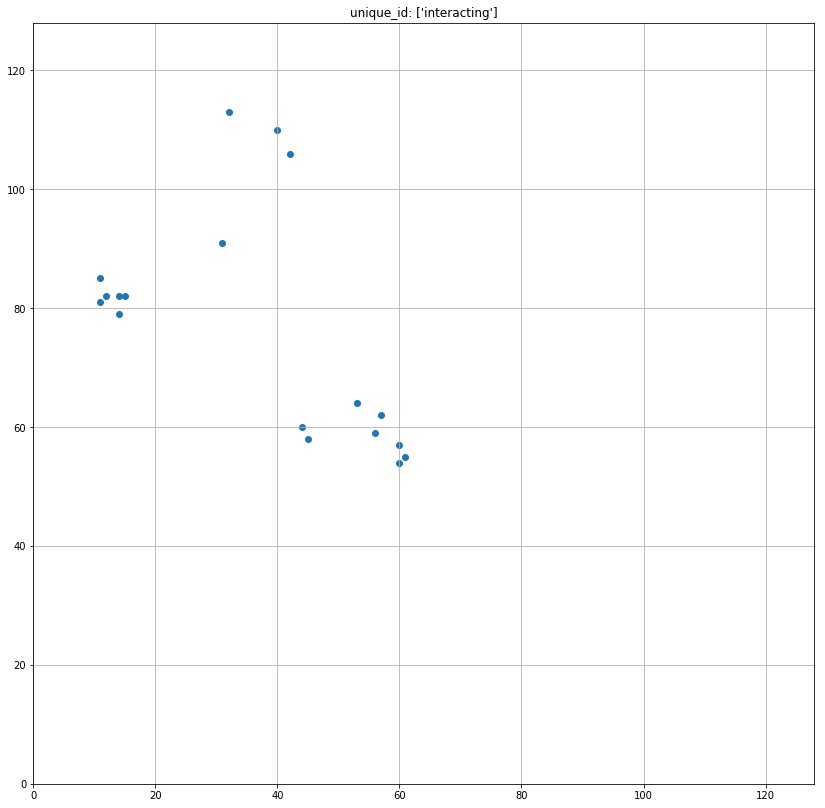

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline
wrd = ['interacting']

print pd.DataFrame(model.most_similar(positive=wrd, negative=[], topn=20)).head()

arrx, arry = retina.fingerprint_x_y(wrd)
print arrx
print arry
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1,1,1)
ax.scatter(arrx,arry)
plt.axis([0,128,0,128])
plt.grid()
plt.title("unique_id: {}".format(wrd))
#plt.savefig("fingerprints/{}.png".format(unique_id))
plt.show()